## Chapter 16 - Metric-Predicted Variable on One or Two Groups

- [16.1 - Estimating the mean and standard deviation of a normal distribution](#16.1---Estimating-the-mean-and-standard-deviation-of-a-normal-distribution)
- [16.2 - Outliers and robust estimation: the t distribution](#16.2---Outliers-and-robust-estimation:-the-t-distribution)
- [16.3 - Two Groups](#16.2---Two-Groups)


In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from scipy.stats import norm, t
from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

In [2]:
%load_ext watermark
%watermark -p pandas,numpy,pymc3,matplotlib,seaborn,scipy

pandas    : 1.3.5
numpy     : 1.22.0
pymc3     : not installed
matplotlib: 3.5.1
seaborn   : 0.11.2
scipy     : 1.7.3



### Data

In [3]:
df = pd.read_csv('data/TwoGroupIQ.csv', dtype={'Group':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Score   120 non-null    int64   
 1   Group   120 non-null    category
dtypes: category(1), int64(1)
memory usage: 1.3 KB


In [4]:
df.head()

,Score,Group
0,102,Smart Drug
1,107,Smart Drug
2,92,Smart Drug
3,101,Smart Drug
4,110,Smart Drug


In [5]:
# Mean and standard deviation
df.groupby('Group').agg(['mean', 'std'])

Score           
                  mean        std
Group                            
Placebo     100.035088  17.894497
Smart Drug  107.841270  25.445201

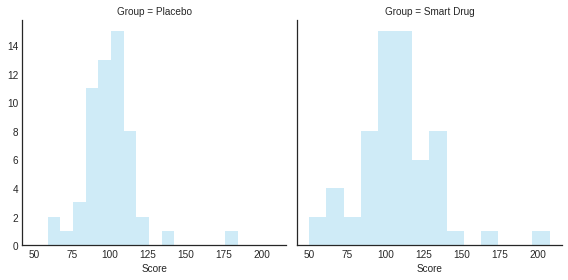

In [6]:
fg = sns.FacetGrid(df, col='Group', height=4)
fg.map(sns.distplot, 'Score', kde=False, color='#87ceeb');

In [7]:
# We are only interested in the scores of group 'Smart Drug'
y = df['Score'][df.Group == 'Smart Drug']

### 16.1 - Estimating the mean and standard deviation of a normal distribution

#### Model (Kruschke, 2015)

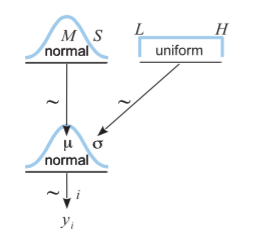

In [8]:
Image('images/fig16_2.png', width=300)

In [9]:
with pm.Model() as model:
    mu = pm.Normal('mu', y.mean(), sd=y.std())
    sigma = pm.Uniform('sigma', y.std()/1000, y.std()*1000)
    
    # PyMC's Normal likelihood can take either precision or standard deviation as an argument.
    likelihood = pm.Normal('likelihood', mu, sd=sigma, observed=y)

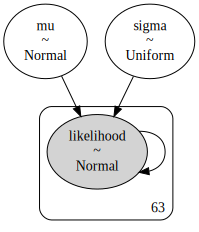

In [10]:
pm.model_to_graphviz(model)

In [11]:
with model:
    trace = pm.sample(2000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 6 seconds.


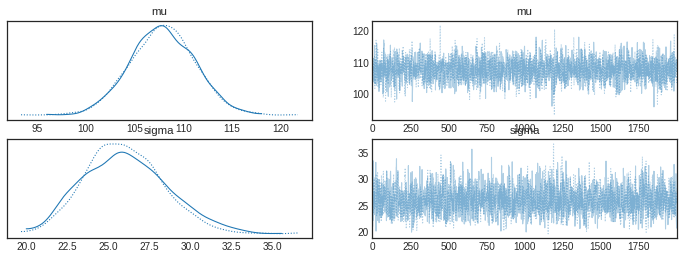

In [12]:
az.plot_trace(trace);

#### Figure 16.3

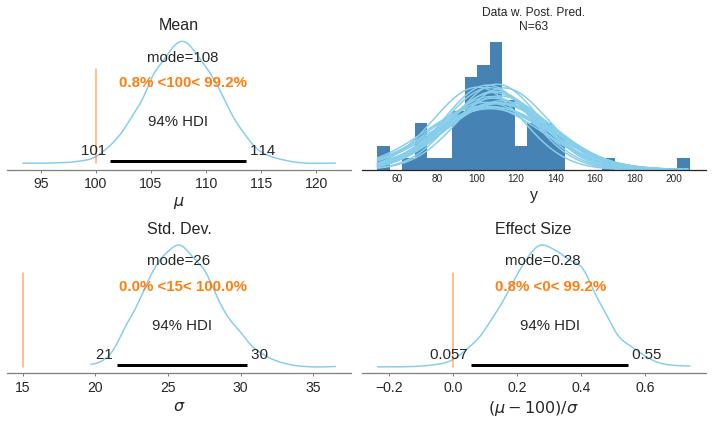

In [13]:
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2,2, figsize=(10,6))

font_d = {'size':16}

# Upper left
pm.plot_posterior(trace.posterior['mu'], point_estimate='mode', ref_val=100, ax=ax1, color=color)
ax1.set_xlabel('$\mu$', fontdict=font_d)
ax1.set_title('Mean', fontdict=font_d)

# Upper right
tr_len = trace.posterior.sizes['draw']
# Plot only 20 posterior prediction curves. 
n_curves = 20
# Create an index of length 20 with which we step through the trace.
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
x_range = np.arange(y.min(), y.max())
x = np.tile(x_range.reshape(-1,1), (1,n_curves))
#x = np.linspace(y.min(), y.max(), n_curves)

ax2.hist(y, bins=25, density=True, color='steelblue')
#ax2.plot(x, norm.pdf(x, trace.posterior['mu'][stepIdxVec], trace.posterior['sigma'][stepIdxVec]), c=color)
ax2.plot(x, norm.pdf(x, trace.posterior['mu'].sel(chain=0,draw=stepIdxVec), trace.posterior['sigma'].sel(chain=0,draw=stepIdxVec)), c=color)
ax2.set_xlabel('y', fontdict=font_d)
ax2.set_title('Data w. Post. Pred.\nN=63')
[ax2.spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
ax2.yaxis.set_visible(False)

# Lower left
pm.plot_posterior(trace.posterior['sigma'], point_estimate='mode', ref_val=15, ax=ax3, color=color)
ax3.set_xlabel('$\sigma$', fontdict=font_d)
ax3.set_title('Std. Dev.', fontdict=font_d)

# Lower right
pm.plot_posterior((trace.posterior['mu']-100)/trace.posterior['sigma'], point_estimate='mode', ref_val=0,
                  ax=ax4, color=color)
ax4.set_title('Effect Size', fontdict=font_d)
ax4.set_xlabel('$(\mu - 100)/\sigma$', fontdict=font_d)

plt.tight_layout();

In [14]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,107.869,3.319,101.296,113.645,0.067,0.047,2467.0,2066.0,1.0
sigma,26.024,2.455,21.477,30.456,0.053,0.037,2143.0,2285.0,1.0


Mean of *mu* is 108ish, mean of *sigma* is 26ish.  What is the mean effect size (e.g., (mean-100)/sigma)?  About 0.3 or so?  Did you forget that *mu* and *sigma* are simply 2 dimensions of a multivariate posterior?  To determine our posterior for the effect size, we need to calculate the effect size for each *mu*-*sigma* **pair** that we have in our trace (our logbook).  Then we can take the mean of these effect sizes.

In [15]:
((trace.posterior['mu']-100)/trace.posterior['sigma']).mean()

<xarray.DataArray ()>
array(0.30516408)

Fortunately (for you), your initial guess wasn't that far off because *mu* and *sigma* are distributed more or less independently.  But next time you may not be so lucky!

In [16]:
# test mu parameter against 100 (definitionally 'average' within the population)
(trace.posterior['mu'] > 100).mean()

<xarray.DataArray 'mu' ()>
array(0.99225)

In [17]:
# test mu parameter against 15 (definitionally the SD of the population)
(trace.posterior['sigma'] > 15).mean()

<xarray.DataArray 'sigma' ()>
array(1.)

In [18]:
# test the standardized effect size against zero
# i.e., what is the probability that the mean is > 0 SDs above 100?
(((trace.posterior['mu']-100)/trace.posterior['sigma']) > 0).mean()

<xarray.DataArray ()>
array(0.99225)

In [19]:
# test effect size against 0.1 (e.g., top of Kruschke's ROPE)
# i.e., what is the probability that the mean is > 0.1 SDs above 100?
(((trace.posterior['mu']-100)/trace.posterior['sigma'])>0.1).mean()

<xarray.DataArray ()>
array(0.94475)

### 16.2 - Outliers and robust estimation: the t distribution

#### Model

In [20]:
with pm.Model() as model2:
    mu = pm.Normal('mu', y.mean(), sd=y.std())
    sigma = pm.Uniform('sigma', y.std()/1000, y.std()*1000)
    nu_minus1 = pm.Exponential('nu_minus1', 1/29)
    nu = pm.Deterministic('nu', nu_minus1+1)
    
    likelihood = pm.StudentT('likelihood', nu,  mu, sd=sigma, observed=y)

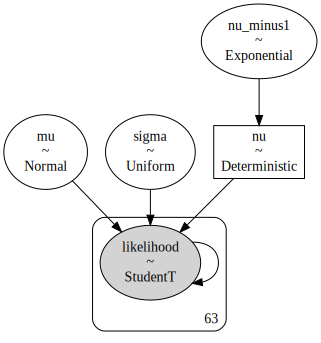

In [21]:
pm.model_to_graphviz(model2)

In [22]:
with model2:
    trace2 = pm.sample(5000, cores=4, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, nu_minus1]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 26 seconds.


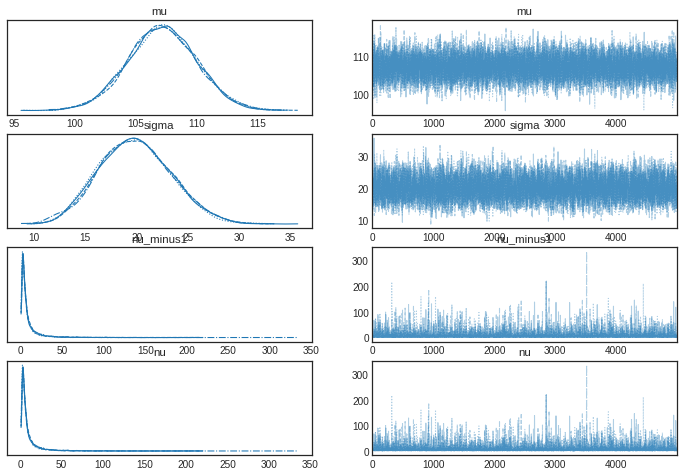

In [23]:
az.plot_trace(trace2);

#### Figure 16.9

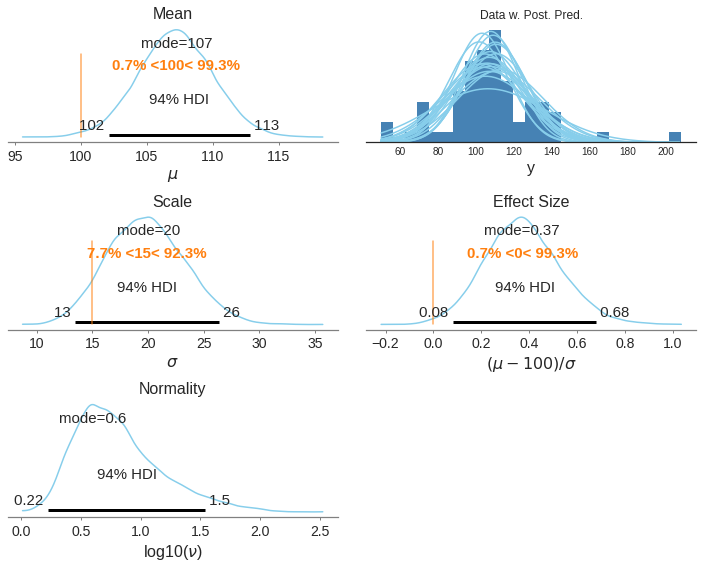

In [24]:
fig, [(ax1, ax2), (ax3, ax4), (ax5, ax6)] = plt.subplots(3,2, figsize=(10,8))

# Upper left
pm.plot_posterior(trace2.posterior['mu'], point_estimate='mode', ref_val=100, ax=ax1, color=color)
ax1.set_xlabel('$\mu$', fontdict=font_d)
ax1.set_title('Mean', fontdict=font_d)

# Upper right
tr_len = trace.posterior.sizes['draw']
n_curves = 20
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
x_range = np.arange(y.min(), y.max())
x = np.tile(x_range.reshape(-1,1), (1,20))

ax2.hist(y, bins=25, density=True, color='steelblue')
ax2.plot(x, norm.pdf(x, trace2.posterior['mu'].sel(chain=0,draw=stepIdxVec), trace2.posterior['sigma'].sel(chain=0,draw=stepIdxVec)), c='#87ceeb')
ax2.set_xlabel('y', fontdict=font_d)
ax2.set_title('Data w. Post. Pred.')
[ax2.spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
ax2.yaxis.set_visible(False)

# Middle left
pm.plot_posterior(trace2.posterior['sigma'], point_estimate='mode', ref_val=15, ax=ax3, color=color)
ax3.set_xlabel('$\sigma$', fontdict=font_d)
ax3.set_title('Scale', fontdict=font_d)

# Middle right
pm.plot_posterior((trace2.posterior['mu']-100)/trace2.posterior['sigma'], point_estimate='mode', ref_val=0,
                  ax=ax4, color=color)
ax4.set_title('Effect Size', fontdict=font_d)
ax4.set_xlabel('$(\mu - 100)/\sigma$', fontdict=font_d)

# Lower left
pm.plot_posterior(np.log10(trace2.posterior['nu']), point_estimate='mode', ax=ax5, color=color)
ax5.set_title('Normality', fontdict=font_d)
ax5.set_xlabel(r'log10($\nu$)', fontdict=font_d)

plt.tight_layout();
ax6.set_visible(False)

Note that *sigma* does **not** control the standard deviation of the *t*-distribution.  This means that comparing *sigma* against a value of 15 **is not meaningful**.  More importantly, this means that (*mu* - 100)/*sigma* is **not** a conventional standardized effect size.

In [25]:
az.summary(trace2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,107.177,2.841,102.091,112.786,0.026,0.019,11578.0,11100.0,1.0
sigma,19.855,3.488,13.413,26.393,0.042,0.029,6816.0,6669.0,1.0
nu_minus1,9.078,14.170,0.072,28.741,0.164,0.116,7111.0,8687.0,1.0
nu,10.078,14.170,1.072,29.741,0.164,0.116,7111.0,8687.0,1.0


In [26]:
# test mu parameter against 100 (definitionally 'average' within the population)
(trace2.posterior['mu'] > 100).mean()

<xarray.DataArray 'mu' ()>
array(0.9933)

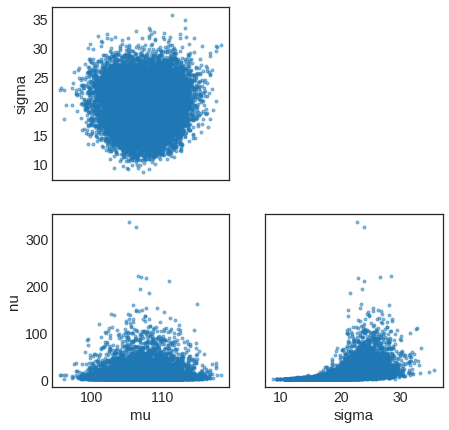

In [27]:
# lower alpha to see where the vast majority of samples are
alpha = 0.5
#alpha = 0.005
az.plot_pair(trace2, var_names=['mu','sigma','nu'], scatter_kwargs={'alpha': alpha}, figsize=(7,7));

### 16.2 - Two Groups

#### Model (Kruschke, 2015)

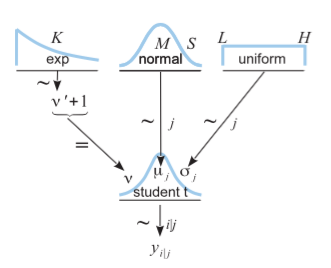

In [28]:
Image('images/fig16_11.png', width=400)

In [29]:
grp_idx = df.Group.cat.codes.values
grp_codes = df.Group.cat.categories
n_grps = grp_codes.size

with pm.Model() as model3:
    mu = pm.Normal('mu', df.Score.mean(), sd=df.Score.std(), shape=n_grps)
    sigma = pm.Uniform('sigma', df.Score.std()/1000, df.Score.std()*1000, shape=n_grps)
    nu_minus1 = pm.Exponential('nu_minus1', 1/29)
    nu = pm.Deterministic('nu', nu_minus1+1)
        
    likelihood = pm.StudentT('likelihood', nu,  mu[grp_idx], sd=sigma[grp_idx], observed=df.Score)

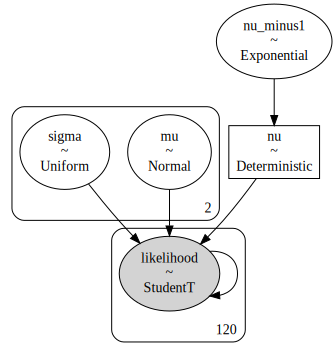

In [30]:
pm.model_to_graphviz(model3)

In [31]:
with model3:
    trace3 = pm.sample(5000, cores=4, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, nu_minus1]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 31 seconds.


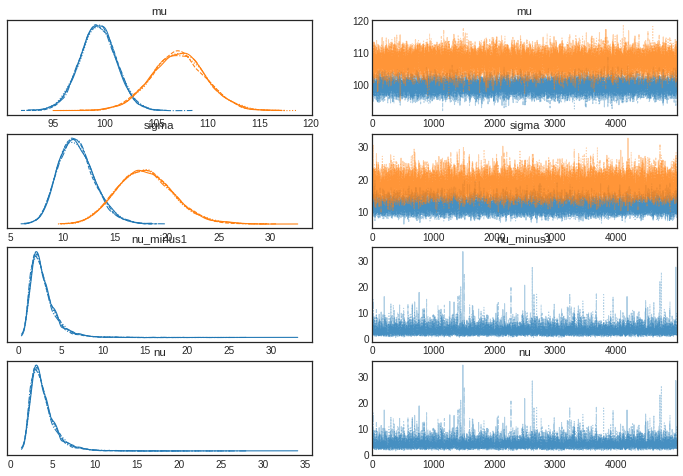

In [32]:
az.plot_trace(trace3);

#### Figure 16.12

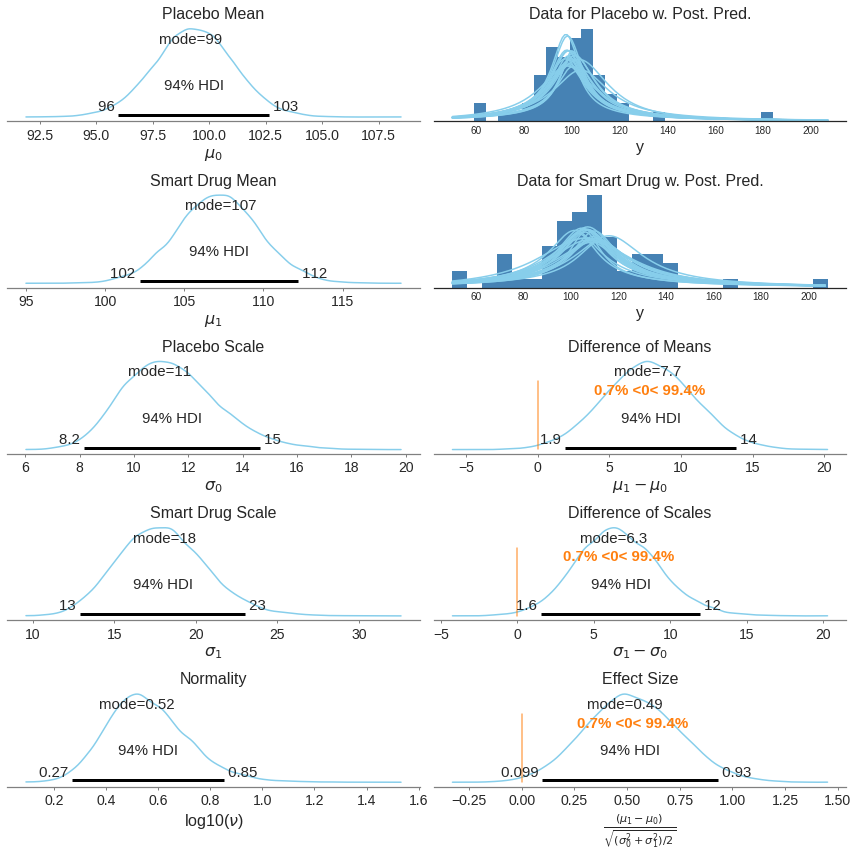

In [33]:
tr3_mu0 = trace3.posterior['mu'].sel(mu_dim_0=0)
tr3_mu1 = trace3.posterior['mu'].sel(mu_dim_0=1)
tr3_sigma0 = trace3.posterior['sigma'].sel(sigma_dim_0=0)
tr3_sigma1 = trace3.posterior['sigma'].sel(sigma_dim_0=1)
tr3_nu = np.log10(trace3.posterior['nu'])

fig, axes = plt.subplots(5,2, figsize=(12, 12))

# Left column figs
l_trace_vars = (tr3_mu0, tr3_mu1, tr3_sigma0, tr3_sigma1, tr3_nu)
l_axes_idx = np.arange(5)
l_xlabels = ('$\mu_0$', '$\mu_1$', '$\sigma_0$', '$\sigma_1$', r'log10($\nu$)')
l_titles = ('Placebo Mean', 'Smart Drug Mean', 'Placebo Scale', 'Smart Drug Scale', 'Normality')

for var, ax_i, xlabel, title in zip(l_trace_vars, l_axes_idx, l_xlabels, l_titles): 
    pm.plot_posterior(var, point_estimate='mode', ax=axes[ax_i,0], color=color)
    axes[ax_i,0].set_xlabel(xlabel, font_d)
    axes[ax_i,0].set_title(title, font_d)

# Right column figs
tr_len = trace3.posterior.sizes['draw']
n_curves = 20
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
x_range = np.arange(df.Score.min(), df.Score.max())
x = np.tile(x_range.reshape(-1,1), (1,n_curves))

# 1
axes[0,1].hist(df.Score[df.Group == 'Placebo'], bins=25, density=True, color='steelblue')
axes[0,1].plot(x, t.pdf(x, loc=tr3_mu0.sel(chain=0,draw=stepIdxVec), scale=tr3_sigma0.sel(chain=0,draw=stepIdxVec),
                        df=tr3_nu.sel(chain=0,draw=stepIdxVec)), c='#87ceeb')
axes[0,1].set_xlabel('y', font_d)
[axes[0,1].spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
axes[0,1].yaxis.set_visible(False)
axes[0,1].set_title('Data for Placebo w. Post. Pred.', font_d)

# 2
axes[1,1].hist(df.Score[df.Group == 'Smart Drug'], bins=25, density=True, color='steelblue')
axes[1,1].plot(x, t.pdf(x, loc=tr3_mu1.sel(chain=0,draw=stepIdxVec), scale=tr3_sigma1.sel(chain=0,draw=stepIdxVec),
                        df=tr3_nu.sel(chain=0,draw=stepIdxVec)), c='#87ceeb')
axes[1,1].set_xlabel('y', font_d)
[axes[1,1].spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
axes[1,1].yaxis.set_visible(False)
axes[1,1].set_title('Data for Smart Drug w. Post. Pred.', font_d)

# 3-5
r_vars = (tr3_mu1-tr3_mu0,
          tr3_sigma1-tr3_sigma0,
          (tr3_mu1-tr3_mu0)/np.sqrt((tr3_sigma0**2+tr3_sigma1**2)/2))
r_axes_idx = np.arange(start=2, stop=5)
r_xlabels = ('$\mu_1 - \mu_0$',
             '$\sigma_1 - \sigma_0$',
             r'$\frac{(\mu_1-\mu_0)}{\sqrt{(\sigma_0^2+\sigma_1^2)/2}}$')
r_titles = ('Difference of Means',
            'Difference of Scales',
            'Effect Size')

for var, ax_i, xlabel, title in zip(r_vars, r_axes_idx, r_xlabels, r_titles):
    pm.plot_posterior(var, point_estimate='mode', ref_val=0, ax=axes[ax_i,1], color=color)
    axes[ax_i,1].set_xlabel(xlabel, font_d)
    axes[ax_i,1].set_title(title, font_d)

plt.tight_layout();

Again, the lower right panel is **not** our belief about conventional measures of standardized effect size.  We are using a *t*-distribution, which means that *sigma* is **not** the SD.

In [34]:
# mean of the placebo group's location parameter
trace3.posterior['mu'].mean(dim=['draw','chain'])[0]

<xarray.DataArray 'mu' ()>
array(99.31634926)
Coordinates:
    mu_dim_0  int64 0

In [35]:
# mean of the 'smart drug' group's location parameter
trace3.posterior['mu'].mean(dim=['draw','chain'])[1]

<xarray.DataArray 'mu' ()>
array(107.11612706)
Coordinates:
    mu_dim_0  int64 1

In [36]:
# belief about the difference in location parameters (i.e., the unstandardized effect size)
(trace3.posterior['mu'].sel(mu_dim_0=0) - trace3.posterior['mu'].sel(mu_dim_0=1)).mean()

<xarray.DataArray 'mu' ()>
array(-7.7997778)

In [37]:
# probability smart drug group location > placebo group location
(trace3.posterior['mu'].sel(mu_dim_0=1) > trace3.posterior['mu'].sel(mu_dim_0=0)).mean()

<xarray.DataArray 'mu' ()>
array(0.9935)